<a href="https://colab.research.google.com/github/baovin/ML_MERC/blob/main/Another_copy_of_CREMA_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
import numpy as np

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchaudio
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import copy


In [2]:
#@title Download dataset

!gdown 1CdjCD2amHDsjJFfb5OuTbIfwEikgn6u-
!unzip cremad.zip

Streaming output truncated to the last 5000 lines.
  inflating: cremad/Image-01-FPS/1033_IEO_SAD_HI/00000.jpg  
  inflating: cremad/Image-01-FPS/1033_IEO_SAD_HI/00029.jpg  
   creating: cremad/Image-01-FPS/1033_IOM_NEU_XX/
  inflating: cremad/Image-01-FPS/1033_IOM_NEU_XX/00058.jpg  
  inflating: cremad/Image-01-FPS/1033_IOM_NEU_XX/00000.jpg  
  inflating: cremad/Image-01-FPS/1033_IOM_NEU_XX/00029.jpg  
   creating: cremad/Image-01-FPS/1057_TIE_NEU_XX/
  inflating: cremad/Image-01-FPS/1057_TIE_NEU_XX/00058.jpg  
  inflating: cremad/Image-01-FPS/1057_TIE_NEU_XX/00000.jpg  
  inflating: cremad/Image-01-FPS/1057_TIE_NEU_XX/00029.jpg  
   creating: cremad/Image-01-FPS/1081_MTI_FEA_XX/
  inflating: cremad/Image-01-FPS/1081_MTI_FEA_XX/00058.jpg  
  inflating: cremad/Image-01-FPS/1081_MTI_FEA_XX/00000.jpg  
  inflating: cremad/Image-01-FPS/1081_MTI_FEA_XX/00087.jpg  
  inflating: cremad/Image-01-FPS/1081_MTI_FEA_XX/00029.jpg  
   creating: cremad/Image-01-FPS/1049_ITH_DIS_XX/
  inflating: crem

In [3]:
!git clone https://github.com/baovin/ML_MERC.git

Cloning into 'ML_MERC'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 54 (delta 12), reused 44 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 359.71 KiB | 1.43 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [4]:
#@title Dataloader

class CramedDataset(Dataset):

    def __init__(self, args, data, train=True):
        self.args = args
        self.image = []
        self.audio = []
        self.label = []
        self.train = train
        self.audio_length = 256

        class_dict = {'NEU':0, 'HAP':1, 'SAD':2, 'FEA':3, 'DIS':4, 'ANG':5}

        self.visual_feature_path = args.visual_path
        self.audio_feature_path = args.audio_path

        for item in data:
            audio_path = os.path.join(self.audio_feature_path, item[0] + '.wav')
            visual_path = os.path.join(self.visual_feature_path, 'Image-{:02d}-FPS'.format(self.args.fps), item[0])

            if os.path.exists(audio_path) and os.path.exists(visual_path):
                self.image.append(visual_path)
                self.audio.append(audio_path)
                self.label.append(class_dict[item[1]])
            else:
                continue


    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):

        # audio

        waveform, sr = torchaudio.load(self.audio[idx])
        fbank = torchaudio.compliance.kaldi.fbank(
                waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

        n_frames = fbank.shape[0]

        p = self.audio_length - n_frames
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:self.audio_length, :]

        fbank = fbank.unsqueeze(0)

        if self.train:
            transform = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        # Visual
        image_samples = os.listdir(self.image[idx])
        select_index = np.random.choice(len(image_samples), size=self.args.fps, replace=False)
        select_index.sort()

        img = Image.open(os.path.join(self.image[idx], image_samples[select_index[0]])).convert('RGB')
        img = transform(img)

        # label
        label = self.label[idx]

        return fbank, img, label

def load_cremad(args):
    train_csv = '/content/ML_MERC/MERC-main/data/CREMAD/train.csv'
    test_csv = '/content/ML_MERC/MERC-main/data/CREMAD/test.csv'

    train_df = pd.read_csv(train_csv, header=None)
    train, dev = train_test_split(train_df, test_size=0.1)

    test = pd.read_csv(test_csv, header=None)

    train_dataset = CramedDataset(args, train.to_numpy(), True)
    dev_dataset = CramedDataset(args, dev.to_numpy(), False)
    test_dataset = CramedDataset(args, test.to_numpy(), False)

    return train_dataset, dev_dataset, test_dataset

In [5]:
import argparse
args = argparse.Namespace(dataset='CREMAD',
          modulation='OGM_GE',
          fusion_method='concat',
          fps=1, audio_path='/content/cremad/AudioWAV/',
          visual_path='/content/cremad/',
          batch_size=1, epochs=10, optimizer='adam',
          learning_rate=0.0002, lr_decay_step=70, lr_decay_ratio=0.1,
          ckpt_path='/content/ML_MERC/MERC-main/ckpt',
          train=True, use_tensorboard=False,
          tensorboard_path=None, random_seed=0)

In [6]:
train_dataset, dev_dataset, test_dataset = load_cremad(args)

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size,
                            shuffle=True, pin_memory=True)

dev_dataloader = DataLoader(dev_dataset, batch_size=args.batch_size,
                          shuffle=False, pin_memory=True)

test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size,
                            shuffle=False, pin_memory=True)

print('Train: {}, Dev: {}, Test: {}'.format(len(train_dataloader), len(dev_dataloader), len(test_dataloader)))

Train: 6028, Dev: 670, Test: 744


In [7]:
print(len(train_dataloader))

6028


torch.Size([1, 256, 128])
torch.Size([3, 224, 224])


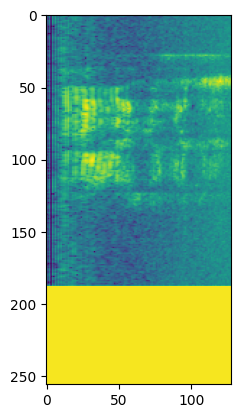

In [8]:
spec, img, label = train_dataset[0]
print(spec.shape)
print(img.shape)
import matplotlib.pyplot as plt
plt.imshow(spec[0,:,:].squeeze())



In [9]:
#@title Visual model
import matplotlib.pyplot as plt

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(Flatten(),
                                 nn.Linear(gate_channels, gate_channels // reduction_ratio),
                                 nn.ReLU(),
                                 nn.Linear(gate_channels // reduction_ratio, gate_channels))
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool )
            elif pool_type == 'max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool)
            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)


class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)
        return x * scale


class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.SpatialGate = SpatialGate()

    def forward(self, x):
        x_out = self.ChannelGate(x)
        x_out = self.SpatialGate(x_out)

        return x_out

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class MulScaleBlock(nn.Module):
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(MulScaleBlock, self).__init__()
        norm_layer = nn.BatchNorm2d
        scale_width = int(planes / 4)

        self.scale_width = scale_width

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=False)

        self.conv1_2_1 = conv3x3(scale_width, scale_width)
        self.bn1_2_1 = norm_layer(scale_width)
        self.conv1_2_2 = conv3x3(scale_width, scale_width)
        self.bn1_2_2 = norm_layer(scale_width)
        self.conv1_2_3 = conv3x3(scale_width, scale_width)
        self.bn1_2_3 = norm_layer(scale_width)
        self.conv1_2_4 = conv3x3(scale_width, scale_width)
        self.bn1_2_4 = norm_layer(scale_width)

        self.conv2_2_1 = conv3x3(scale_width, scale_width)
        self.bn2_2_1 = norm_layer(scale_width)
        self.conv2_2_2 = conv3x3(scale_width, scale_width)
        self.bn2_2_2 = norm_layer(scale_width)
        self.conv2_2_3 = conv3x3(scale_width, scale_width)
        self.bn2_2_3 = norm_layer(scale_width)
        self.conv2_2_4 = conv3x3(scale_width, scale_width)
        self.bn2_2_4 = norm_layer(scale_width)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        sp_x = torch.split(out, self.scale_width, 1)

        ##########################################################
        out_1_1 = self.conv1_2_1(sp_x[0])
        out_1_1 = self.bn1_2_1(out_1_1)
        out_1_1_relu = self.relu(out_1_1)
        out_1_2 = self.conv1_2_2(out_1_1_relu + sp_x[1])
        out_1_2 = self.bn1_2_2(out_1_2)
        out_1_2_relu = self.relu(out_1_2)
        out_1_3 = self.conv1_2_3(out_1_2_relu + sp_x[2])
        out_1_3 = self.bn1_2_3(out_1_3)
        out_1_3_relu = self.relu(out_1_3)
        out_1_4 = self.conv1_2_4(out_1_3_relu + sp_x[3])
        out_1_4 = self.bn1_2_4(out_1_4)
        output_1 = torch.cat([out_1_1, out_1_2, out_1_3, out_1_4], dim=1)

        out_2_1 = self.conv2_2_1(sp_x[0])
        out_2_1 = self.bn2_2_1(out_2_1)
        out_2_1_relu = self.relu(out_2_1)
        out_2_2 = self.conv2_2_2(out_2_1_relu + sp_x[1])
        out_2_2 = self.bn2_2_2(out_2_2)
        out_2_2_relu = self.relu(out_2_2)
        out_2_3 = self.conv2_2_3(out_2_2_relu + sp_x[2])
        out_2_3 = self.bn2_2_3(out_2_3)
        out_2_3_relu = self.relu(out_2_3)
        out_2_4 = self.conv2_2_4(out_2_3_relu + sp_x[3])
        out_2_4 = self.bn2_2_4(out_2_4)
        output_2 = torch.cat([out_2_1, out_2_2, out_2_3, out_2_4], dim=1)

        out = output_1 + output_2

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class AttentionBlock(nn.Module):
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(AttentionBlock, self).__init__()
        norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        self.cbam = CBAM(planes, 16)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.cbam(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class MANet(nn.Module):

    def __init__(self, block_b, block_m, block_a, layers, num_classes=12666):
        super(MANet, self).__init__()
        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block_b, 64, 64, layers[0])
        self.layer2 = self._make_layer(block_b, 64, 128, layers[1], stride=2)

        # In this branch, each BasicBlock replaced by AttentiveBlock.
        self.layer3_1_p1 = self._make_layer(block_a, 128, 256, layers[2], stride=2)
        self.layer4_1_p1 = self._make_layer(block_a, 256, 512, layers[3], stride=1)

        self.layer3_1_p2 = self._make_layer(block_a, 128, 256, layers[2], stride=2)
        self.layer4_1_p2 = self._make_layer(block_a, 256, 512, layers[3], stride=1)

        self.layer3_1_p3 = self._make_layer(block_a, 128, 256, layers[2], stride=2)
        self.layer4_1_p3 = self._make_layer(block_a, 256, 512, layers[3], stride=1)

        self.layer3_1_p4 = self._make_layer(block_a, 128, 256, layers[2], stride=2)
        self.layer4_1_p4 = self._make_layer(block_a, 256, 512, layers[3], stride=1)

        # In this branch, each BasicBlock replaced by MulScaleBlock.
        self.layer3_2 = self._make_layer(block_m, 128, 256, layers[2], stride=2)
        self.layer4_2 = self._make_layer(block_m, 256, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc_1 = nn.Linear(512, num_classes)
        self.fc_2 = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or inplanes != planes:
            downsample = nn.Sequential(conv1x1(inplanes, planes, stride), norm_layer(planes))
        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(inplanes, planes))
        return nn.Sequential(*layers)

    def _forward_impl(self, x, return_embedding=False):

        x = x.squeeze(dim=0)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)

        # branch 1 ############################################
        patch_11 = x[:, :, 0:14, 0:14]
        patch_12 = x[:, :, 0:14, 14:28]
        patch_21 = x[:, :, 14:28, 0:14]
        patch_22 = x[:, :, 14:28, 14:28]

        branch_1_p1_out = self.layer3_1_p1(patch_11)
        branch_1_p1_out = self.layer4_1_p1(branch_1_p1_out)

        branch_1_p2_out = self.layer3_1_p2(patch_12)
        branch_1_p2_out = self.layer4_1_p2(branch_1_p2_out)

        branch_1_p3_out = self.layer3_1_p3(patch_21)
        branch_1_p3_out = self.layer4_1_p3(branch_1_p3_out)

        branch_1_p4_out = self.layer3_1_p4(patch_22)
        branch_1_p4_out = self.layer4_1_p4(branch_1_p4_out)

        branch_1_out_1 = torch.cat([branch_1_p1_out, branch_1_p2_out], dim=3)
        branch_1_out_2 = torch.cat([branch_1_p3_out, branch_1_p4_out], dim=3)
        branch_1_out = torch.cat([branch_1_out_1, branch_1_out_2], dim=2)

        branch_1_out = self.avgpool(branch_1_out)
        branch_1_out_embedding = torch.flatten(branch_1_out, 1)
        branch_1_out = self.fc_1(branch_1_out_embedding)

        # branch 2 ############################################
        branch_2_out = self.layer3_2(x)
        branch_2_out = self.layer4_2(branch_2_out)
        branch_2_out = self.avgpool(branch_2_out)
        branch_2_out_embedding = torch.flatten(branch_2_out, 1)
        branch_2_out = self.fc_2(branch_2_out_embedding)

        if return_embedding:
            return torch.cat([branch_1_out_embedding, branch_2_out_embedding], dim=1)
        else:
            return branch_1_out, branch_2_out

    def forward(self, x, return_embedding=False):
        return self._forward_impl(x, return_embedding)


def manet(**kwargs):
    return MANet(block_b=BasicBlock, block_m=MulScaleBlock, block_a=AttentionBlock, layers=[2, 2, 2, 2], **kwargs)

class RecorderMeter(object):
    """Computes and stores the minimum loss value and its epoch index"""

    def __init__(self, total_epoch):
        self.reset(total_epoch)

    def reset(self, total_epoch):
        self.total_epoch = total_epoch
        self.current_epoch = 0
        self.epoch_losses = np.zeros((self.total_epoch, 2), dtype=np.float32)    # [epoch, train/val]
        self.epoch_accuracy = np.zeros((self.total_epoch, 2), dtype=np.float32)  # [epoch, train/val]

    def update(self, idx, train_loss, train_acc, val_loss, val_acc):
        self.epoch_losses[idx, 0] = train_loss * 30
        self.epoch_losses[idx, 1] = val_loss * 30
        self.epoch_accuracy[idx, 0] = train_acc
        self.epoch_accuracy[idx, 1] = val_acc
        self.current_epoch = idx + 1

    def plot_curve(self, save_path):

        title = 'the accuracy/loss curve of train/val'
        dpi = 80
        width, height = 1800, 800
        legend_fontsize = 10
        figsize = width / float(dpi), height / float(dpi)

        fig = plt.figure(figsize=figsize)
        x_axis = np.array([i for i in range(self.total_epoch)])  # epochs
        y_axis = np.zeros(self.total_epoch)

        plt.xlim(0, self.total_epoch)
        plt.ylim(0, 100)
        interval_y = 5
        interval_x = 5
        plt.xticks(np.arange(0, self.total_epoch + interval_x, interval_x))
        plt.yticks(np.arange(0, 100 + interval_y, interval_y))
        plt.grid()
        plt.title(title, fontsize=20)
        plt.xlabel('the training epoch', fontsize=16)
        plt.ylabel('accuracy', fontsize=16)

        y_axis[:] = self.epoch_accuracy[:, 0]
        plt.plot(x_axis, y_axis, color='g', linestyle='-', label='train-accuracy', lw=2)
        plt.legend(loc=4, fontsize=legend_fontsize)

        y_axis[:] = self.epoch_accuracy[:, 1]
        plt.plot(x_axis, y_axis, color='y', linestyle='-', label='valid-accuracy', lw=2)
        plt.legend(loc=4, fontsize=legend_fontsize)

        y_axis[:] = self.epoch_losses[:, 0]
        plt.plot(x_axis, y_axis, color='g', linestyle=':', label='train-loss-x30', lw=2)
        plt.legend(loc=4, fontsize=legend_fontsize)

        y_axis[:] = self.epoch_losses[:, 1]
        plt.plot(x_axis, y_axis, color='y', linestyle=':', label='valid-loss-x30', lw=2)
        plt.legend(loc=4, fontsize=legend_fontsize)

        if save_path is not None:
            fig.savefig(save_path, dpi=dpi, bbox_inches='tight')
            print('Saved figure')
        plt.close(fig)

In [23]:
#@title Audio model

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t, t)


# classes
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class Scale(nn.Module):
    def __init__(self, val):
        super().__init__()
        self.val = val

    def forward(self, x):
        return x * self.val


class SepTrBlock(nn.Module):
    def __init__(self, channels, input_size, heads=3, mlp_dim=128, dim_head=32,
                 down_sample_input=None, project=False, reconstruct=False, dim=128, dropout_tr=0.0):
        super().__init__()
        patch_height, patch_width = pair(input_size)
        self.avg_pool = nn.Identity()
        self.upsample = nn.Identity()
        self.projection = nn.Identity()
        self.reconstruction = nn.Identity()

        if down_sample_input is not None:
            patch_height = patch_height // down_sample_input[0]
            patch_width = patch_width // down_sample_input[1]

            self.avg_pool = nn.AvgPool2d(kernel_size=down_sample_input)
            self.upsample = nn.UpsamplingNearest2d(scale_factor=down_sample_input)

        if project:
            self.projection = nn.Linear(channels, dim)
        if reconstruct:
            self.reconstruction = nn.Sequential(
                nn.Linear(dim, channels),
                Scale(dim ** -0.5)
            )

        self.rearrange_patches_h = Rearrange('b c h w -> b w h c')
        self.rearrange_patches_w = Rearrange('b c h w -> b h w c')

        self.rearrange_in_tr = Rearrange('b c h w -> (b c) h w')
        self.rearrange_out_tr_h = Rearrange('(b c) h w -> b w h c', c=patch_width)
        self.rearrange_out_tr_w = Rearrange('(b c) h w -> b w c h', c=patch_height)

        self.pos_embedding_w = nn.Parameter(torch.randn(1, 1, patch_width + 1, dim))
        self.pos_embedding_h = nn.Parameter(torch.randn(1, 1, patch_height + 1, dim))
        self.transformer_w = Transformer(dim, 1, heads, dim_head, mlp_dim, dropout_tr)
        self.transformer_h = Transformer(dim, 1, heads, dim_head, mlp_dim, dropout_tr)

    def forward(self, x, cls_token):
        x = self.avg_pool(x)
        x = x.squeeze(1)

        # H inference
        h = self.rearrange_patches_h(x)
        h = self.projection(h)

        dim1, dim2, _, _ = h.shape
        if cls_token.shape[0] == 1:
            cls_token = repeat(cls_token, '() () n d -> b w n d', b=dim1, w=dim2)
        else:
            cls_token = repeat(cls_token, 'b () n d -> b w n d', w=dim2)

        h = torch.cat((cls_token, h), dim=2)
        h += self.pos_embedding_h

        h = self.rearrange_in_tr(h)
        h = self.transformer_h(h)
        h = self.rearrange_out_tr_h(h)

        # W inference
        w = self.rearrange_patches_w(h[:, :, 1:, :])

        cls_token = h[:, :, 0, :].unsqueeze(2)
        cls_token = repeat(cls_token.mean((-1, -2)).unsqueeze(1).unsqueeze(1), 'b () d2 e -> b d1 d2 e', d1=w.shape[1])

        w = torch.cat((cls_token, w), dim=2)
        w += self.pos_embedding_w

        w = self.rearrange_in_tr(w)
        w = self.transformer_w(w)
        w = self.rearrange_out_tr_w(w)

        x = self.upsample(w[:, :, :, 1:])
        x = self.reconstruction(x)

        cls_token = w[:, :, :, 0].mean(2).unsqueeze(1).unsqueeze(1)
        return x, cls_token

class SeparableTr(nn.Module):
    def __init__(self, channels=1, input_size=(128, 128), num_classes=35, depth=3, heads=5, mlp_dim=256, dim_head=256,
                 down_sample_input=None, dim=256):
        super().__init__()
        inner_channels = channels

        self.transformer = nn.ModuleList()

        if depth < 1:
            raise Exception("Depth cannot be smaller than 1!")

        self.transformer.append(
            SepTrBlock(channels=inner_channels, input_size=input_size, heads=heads, mlp_dim=mlp_dim,
                       dim_head=dim_head, down_sample_input=down_sample_input, dim=dim, project=True)
        )

        for i in range(1, depth):
            self.transformer.append(
                SepTrBlock(channels=inner_channels, input_size=input_size, heads=heads, mlp_dim=mlp_dim,
                           dim_head=dim_head, down_sample_input=down_sample_input, dim=dim, project=False)
            )

        self.cls_token = nn.Parameter(torch.randn(1, 1, 1, dim))

    def forward(self, x):
        x, cls_token = self.transformer[0](x, self.cls_token)

        for i in range(1, len(self.transformer)):
            x, cls_token = self.transformer[i](x, cls_token)

        cls_token = cls_token[:, 0, 0, :]
        x = cls_token
        return x

In [24]:
#@title Fusion

class SumFusion(nn.Module):
    def __init__(self, input_dim=512, output_dim=100):
        super(SumFusion, self).__init__()
        self.fc_x = nn.Linear(input_dim, output_dim)
        self.fc_y = nn.Linear(input_dim, output_dim)

    def forward(self, x, y):
        output = self.fc_x(x) + self.fc_y(y)
        return x, y, output


class ConcatFusion(nn.Module):
    def __init__(self, input_dim=1024, output_dim=100):
        super(ConcatFusion, self).__init__()
        self.fc_out = nn.Linear(input_dim, output_dim)

    def forward(self, x, y):
        output = torch.cat((x, y), dim=1)
        output = self.fc_out(output)
        return x, y, output


class FiLM(nn.Module):
    """
    FiLM: Visual Reasoning with a General Conditioning Layer,
    https://arxiv.org/pdf/1709.07871.pdf.
    """

    def __init__(self, input_dim=512, dim=512, output_dim=100, x_film=True):
        super(FiLM, self).__init__()

        self.dim = input_dim
        self.fc = nn.Linear(input_dim, 2 * dim)
        self.fc_out = nn.Linear(dim, output_dim)

        self.x_film = x_film

    def forward(self, x, y):

        if self.x_film:
            film = x
            to_be_film = y
        else:
            film = y
            to_be_film = x

        gamma, beta = torch.split(self.fc(film), self.dim, 1)

        output = gamma * to_be_film + beta
        output = self.fc_out(output)

        return x, y, output


class GatedFusion(nn.Module):
    """
    Efficient Large-Scale Multi-Modal Classification,
    https://arxiv.org/pdf/1802.02892.pdf.
    """

    def __init__(self, input_dim=512, dim=512, output_dim=100, x_gate=True):
        super(GatedFusion, self).__init__()

        self.fc_x = nn.Linear(input_dim, dim)
        self.fc_y = nn.Linear(input_dim, dim)
        self.fc_out = nn.Linear(dim, output_dim)

        self.x_gate = x_gate  # whether to choose the x to obtain the gate

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y):
        out_x = self.fc_x(x)
        out_y = self.fc_y(y)

        if self.x_gate:
            gate = self.sigmoid(out_x)
            output = self.fc_out(torch.mul(gate, out_y))
        else:
            gate = self.sigmoid(out_y)
            output = self.fc_out(torch.mul(out_x, gate))

        return out_x, out_y, output


In [25]:
#@title Multimodal model

class AVC_GB(nn.Module):
    def __init__(self, args):
        super(AVC_GB, self).__init__()

        fusion = args.fusion_method
        n_classes = 6


        self.fusion_module = ConcatFusion(input_dim=1280, output_dim=n_classes)


        self.audio_net = SeparableTr(1, (256, 128), num_classes=6, depth=2, heads=2, mlp_dim=256)

        self.visual_net = manet(num_classes=n_classes)
    def forward(self, audio, visual):
        audio = audio.unsqueeze(dim=0)
        visual = visual.unsqueeze(dim=0)
        v = self.visual_net(visual, return_embedding=True)
        a = self.audio_net(audio)
        a, v, out = self.fusion_module(a, v)
        return a, v, out

In [17]:
# model = AVC_GB(args)
# a, v, out = model(spec,img)
# print(a.shape, v.shape, out.shape)



In [33]:
#@title Trainning

from tqdm import tqdm

def train_epoch(args, epoch, model, device, dataloader, optimizer, scheduler, writer=None):
    criterion = nn.CrossEntropyLoss()

    model.train()
    print("Start training ... ")

    _loss = 0

    for step, (spec, image, label) in (pbar := tqdm(enumerate(dataloader), desc='Epoch: {}: '.format(epoch))):
        #pdb.set_trace()
        spec = spec.to(device)
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()

        # TODO: make it simpler and easier to extend
        a, v, out = model(spec.float(), image.float())

        loss = criterion(out, label)
        loss.backward()

        optimizer.step()
        # pbar.set_description('Epoch: {} Loss: {:.4f}'.format(epoch, loss.item()))

        _loss += loss.item()

    scheduler.step()

    return _loss / len(dataloader)

def eval(args, model, device, dataloader, test=False):
    softmax = nn.Softmax(dim=1)

    if args.dataset == 'CREMAD':
        n_classes = 6
    else:
        raise NotImplementedError('Incorrect dataset name {}'.format(args.dataset))

    with torch.no_grad():
        model.eval()
        criterion = nn.CrossEntropyLoss()
        _loss = 0
        golds = []
        preds = []
        for step, (spec, image, label) in enumerate(dataloader):

            spec = spec.to(device)
            image = image.to(device)
            label = label.to(device)

            a, v, out = model(spec.float(), image.float())


            loss = criterion(out, label)
            _loss += loss.item()

            y_hat = torch.argmax(softmax(out), dim=-1)
            golds.extend(label.cpu().numpy())
            preds.extend(y_hat.cpu().numpy())

        wf1 = f1_score(golds, preds, average='weighted')

        if test:
            print(classification_report(golds, preds))
    return _loss / len(dataloader), wf1

In [34]:
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = AVC_GB(args)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=args.learning_rate, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, args.lr_decay_step, args.lr_decay_ratio)

In [ ]:
if args.train:
        best_dev_f1 = 0.0
        best_state = None
        best_epoch = 0

        for epoch in range(args.epochs):
            batch_loss= train_epoch(args, epoch, model, device,
                                        train_dataloader, optimizer, scheduler)
            loss, f1 = eval(args, model, device, dev_dataloader)

            print('Epoch: {}, Train Loss: {}, Dev Loss: {}, F1: {}'.format(epoch, batch_loss, loss, f1))

            if f1 > best_dev_f1:
                best_dev_f1 = f1
                best_state = best_state = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        # Best state
        model.load_state_dict(best_state)
        print('Best model loaded at epoch {} with dev F1: {}'.format(best_epoch, best_dev_f1))
        print("Start testing on test dataset ...")
        _, f1 = eval(args, model, device, test_dataloader, test=True)
        if not os.path.exists(args.ckpt_path):
            os.mkdir(args.ckpt_path)

        model_name = 'best_model_of_dataset_{}_' \
                        'optimizer_{}_' \
                        'epoch_{}_f1_{}.pth'.format(args.dataset,
                                                    args.optimizer,
                                                    epoch, f1)

        saved_dict = {'saved_epoch': epoch,
                        'fusion': args.fusion_method,
                        'f1': f1,
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict()}

        save_dir = os.path.join(args.ckpt_path, model_name)

        torch.save(saved_dict, save_dir)
        print('The best model has been saved at {}.'.format(save_dir))



else:
        loaded_dict = torch.load(args.ckpt_path)
        fusion = loaded_dict['fusion']
        state_dict = loaded_dict['model']

        assert fusion == args.fusion_method, 'inconsistency between fusion method of loaded model and args !'

        model.load_state_dict(state_dict)
        print('Trained model loaded! Testing ...')

        loss, f1 = eval(args, model, device, test_dataloader, test=True)




Start training ... 


Epoch: 0: : 46it [00:17,  2.55it/s]

In [ ]:
checkpoint = torch.load("/content/[02-08]-[21-19]-model_best-acc88.33.pth")
pre_trained_dict = checkpoint['state_dict']
pre_trained_dict = {k.replace('module.', ''): v for k,v in checkpoint['state_dict'].items()}

model.visual_net.load_state_dict(pre_trained_dict)
model.audio_net.load_state_dict(pre_trained_dict)

In [ ]:
# Best state
model.load_state_dict(best_state)
print('Best model loaded at epoch {} with dev F1: {}'.format(best_epoch, best_dev_f1))
print("Start testing on test dataset ...")
_, f1 = eval(args, model, device, test_dataloader, test=True)